In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import gmaps
import requests
import json
from config import gkey

In [2]:
happiness_2021 = pd.read_csv('cleaned_happiness_2021.csv')

# Data Overview

Explain our data set, research questions/hypothesis

# Analysis
brief summary of overall results

In [4]:
corr = happiness_2021[["Happiness score","GDP per capita","Social support",'Healthy life expectancy',"Freedom to make life choices"]].corr()
corr = corr.style.background_gradient(cmap='PRGn')
corr

,Happiness score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices
Happiness score,1.000000,0.795247,0.808799,0.711411,0.579028
GDP per capita,0.795247,1.000000,0.767490,0.856166,0.329454
Social support,0.808799,0.767490,1.000000,0.713057,0.429402
Healthy life expectancy,0.711411,0.856166,0.713057,1.000000,0.340498
Freedom to make life choices,0.579028,0.329454,0.429402,0.340498,1.000000


## Freedom

## GDP

## Life Expectancy

# Hypothesis:

>When healthy life expectancy is high, there is a measurable increase in the Cantrill happiness score. <br>Null Hypothesis (H<sub>0</sub>):  When healthy life expectancy is high, there is no measurable impact in the Cantrill happiness score whatsoever.<br>If p-value is < 0.05 then we reject the null hypothesis. 

In [14]:
grF = happiness_2021[happiness_2021['Healthy life expectancy'] < 60]["Happiness score"]
grD = happiness_2021[happiness_2021['Healthy life expectancy'].between(59.99, 65.40, inclusive='both')]["Happiness score"]
grC = happiness_2021[happiness_2021['Healthy life expectancy'].between(65.40, 67.20, inclusive='both')]["Happiness score"]
grB = happiness_2021[happiness_2021['Healthy life expectancy'].between(67.20, 70.33, inclusive='both')]["Happiness score"]
grA = happiness_2021[happiness_2021['Healthy life expectancy'] > 70.33]["Happiness score"]
st.f_oneway(grA, grB, grC, grD, grF)

F_onewayResult(statistic=31.559923638910274, pvalue=2.9603982004555786e-17)

### Using the ANOVA test, H<sub>0</sub> is rejected.

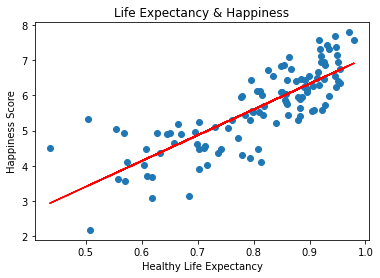

In [9]:
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(52,7),fontsize=15,color="indigo")
plt.xlabel("Healthy Life Expectancy")
plt.ylabel("Happiness Score")
plt.title("Life Expectancy & Happiness")
plt.show()

## Social Support

Per the World Happiness Report: 
>Social support (or having someone to count on in times of trouble) is the national average of the binary responses (either 0 or 1) to the GWP question “If you were in trouble, do you have relatives or friends you can count on to help you whenever you need them, or not?”

### Data Range
The lowest social support value is 0.44 (Benin), meaning 44% of respondents answered yes to the above question. The next lowest value is 0.50 (Morocco), meaning in all but one of the study countries, at least 50% of respondents felt like they had someone to count on in times of trouble. The mean is 0.81 and the highest is 0.98 (Iceland). 

In [5]:
happiness_2021['Social support'].describe()

count    110.000000
mean       0.805196
std        0.124863
min        0.435524
25%        0.713824
50%        0.844487
75%        0.905608
max        0.979858
Name: Social support, dtype: float64

### Hypothesis Testing and Regression
Regression analysis shows a high correlation between social support and happiness (Pearson's r value of 0.81). This correlation is statistically significant, given the p-value calculated in the null hypothesis test is well below 0.05.

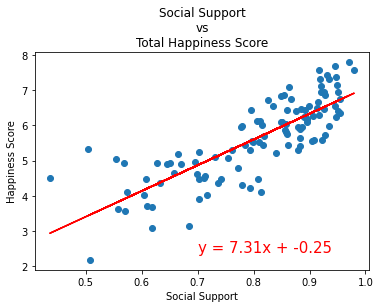

The correlation between social support and happiness is 0.81, suggesting a strong link between the two factors.


In [6]:
x_values = happiness_2021['Social support']
y_values = happiness_2021['Happiness score']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0.7,2.4),fontsize=15,color="red")
plt.xlabel("Social Support")
plt.ylabel("Happiness Score")
plt.title("Social Support\nvs\nTotal Happiness Score")
plt.show()
pr = round(st.pearsonr(x_values,y_values)[0],2)
print(f'The correlation between social support and happiness is {pr}, suggesting a strong link between the two factors.')

In [7]:
# sort dataset and see how many values need to be in each group
h0_test = happiness_2021[["Country","Happiness score","Social support"]]
h0_test = h0_test.sort_values("Social support")

bottom_third = h0_test.iloc[0:37,1]
middle_third = h0_test.iloc[37:74,1]
top_third = h0_test.iloc[74:110,1]

stat,p = st.kruskal(top_third,middle_third,bottom_third)
print(f'The p-value is {p}, which rejects the null hypothesis.')

The p-value is 8.261872947301994e-16, which rejects the null hypothesis.


### Geographic Distribution of Social Support
Countries with the highest social support values are concentrated in Europe (particularly Scandanavia and Eastern Europe) as well as Central Asia. The countries with the lowest social support values are concentrated in Northern and Sub-Saharan Africa, the Middle East, South and South-East Asia. In the Americas, most countries fall into the middle tier of social support, with 6 landing in the top third. Mexico is the notable exception as the one country in the bottom third of nations. 

In [8]:
gmaps.configure(api_key = gkey)
fig = gmaps.figure()

social_sorted = happiness_2021.sort_values('Social support')
top_locations = social_sorted.iloc[74:110,[6,7]]
top_social = social_sorted.iloc[74:110,3]
middle_locations = social_sorted.iloc[37:74,[6,7]]
middle_social = social_sorted.iloc[37:74,3]
bottom_locations = social_sorted.iloc[0:37,[6,7]]
bottom_social = social_sorted.iloc[0:37,3]
                             
fig = gmaps.figure()

symbols_top = gmaps.symbol_layer(top_locations, fill_color='#028833', stroke_color='#028833')
fig.add_layer(symbols_top)

symbols_middle = gmaps.symbol_layer(middle_locations, fill_color='blue', stroke_color='blue')
fig.add_layer(symbols_middle)

symbols_bottom = gmaps.symbol_layer(bottom_locations, fill_color='#E65300', stroke_color='#E65300')
fig.add_layer(symbols_bottom)

fig

Figure(layout=FigureLayout(height='420px'))

In the above map, green dots represent the countries in the top third of social support values. Blue represents the middle third and orange represents the bottom third.

### We all need somebody to lean on
The results of comparing amount of social support to happiness in the study countries strongly suggests that social support positively influences happiness. Humans are social creatures, so it makes sense that having connections to others would increase happiness. 

# Conclusion
include what we might do differently next time